# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect the hero target and location within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consiting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the separable_conv2d_batchnorm() function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block, as covered in the Classroom, comprises of three steps:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters): 
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    merged = layers.concatenate([upsampled, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(merged, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    #Encoder Blocks
    encoder_block_1 = encoder_block(inputs, 32, 2)
    encoder_block_2 = encoder_block(encoder_block_1, 64, 2)
    
    # 1x1 Convolution
    one_one_conv_1 = conv2d_batchnorm(input_layer=encoder_block_2, filters=256, kernel_size=1, strides=1)
    one_one_conv_2 = conv2d_batchnorm(input_layer=one_one_conv_1, filters=256, kernel_size=1, strides=1)
    one_one_conv_3 = conv2d_batchnorm(input_layer=one_one_conv_2, filters=128, kernel_size=1, strides=1)
    
    # Decoder Blocks
    decoder_block_1 = decoder_block(one_one_conv_3, encoder_block_1, 64)
    x = decoder_block(decoder_block_1, inputs, 32)
  
    
    # Output
    output = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)
    return output

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [13]:
learning_rate = 0.002
batch_size = 128
num_epochs = 100
steps_per_epoch = 64
validation_steps = 12
workers = 4

Epoch 1/100
63/64 [============================>.] - ETA: 1s - loss: 0.3984

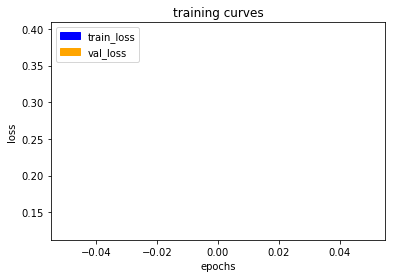

64/64 [==============================] - 114s - loss: 0.3934 - val_loss: 0.1258
Epoch 2/100
63/64 [============================>.] - ETA: 1s - loss: 0.0643

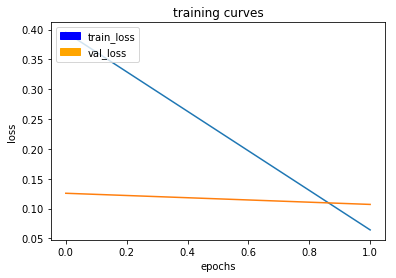

64/64 [==============================] - 112s - loss: 0.0643 - val_loss: 0.1071
Epoch 3/100
63/64 [============================>.] - ETA: 1s - loss: 0.0512

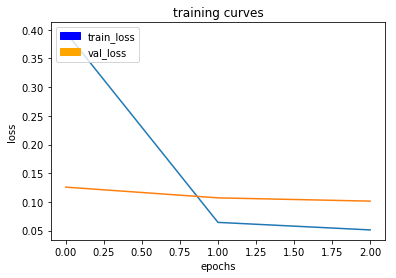

64/64 [==============================] - 112s - loss: 0.0512 - val_loss: 0.1014
Epoch 4/100
63/64 [============================>.] - ETA: 1s - loss: 0.0439

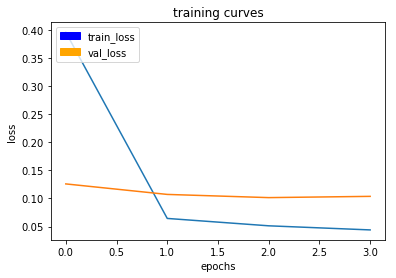

64/64 [==============================] - 112s - loss: 0.0439 - val_loss: 0.1036
Epoch 5/100
63/64 [============================>.] - ETA: 1s - loss: 0.0405

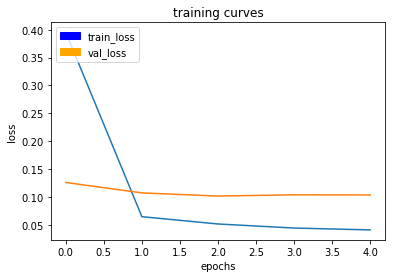

64/64 [==============================] - 111s - loss: 0.0407 - val_loss: 0.1034
Epoch 6/100
63/64 [============================>.] - ETA: 1s - loss: 0.0383

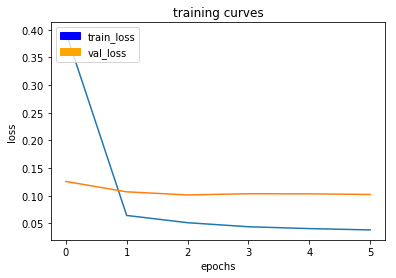

64/64 [==============================] - 112s - loss: 0.0383 - val_loss: 0.1023
Epoch 7/100
63/64 [============================>.] - ETA: 1s - loss: 0.0365

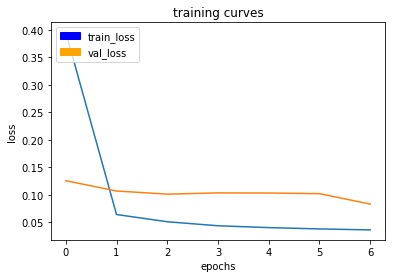

64/64 [==============================] - 111s - loss: 0.0364 - val_loss: 0.0834
Epoch 8/100
63/64 [============================>.] - ETA: 1s - loss: 0.0337

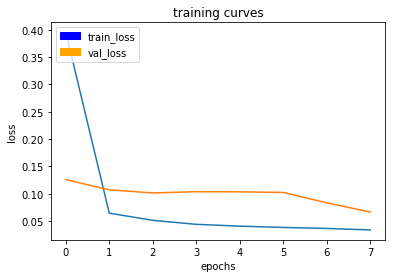

64/64 [==============================] - 112s - loss: 0.0337 - val_loss: 0.0664
Epoch 9/100
63/64 [============================>.] - ETA: 1s - loss: 0.0339

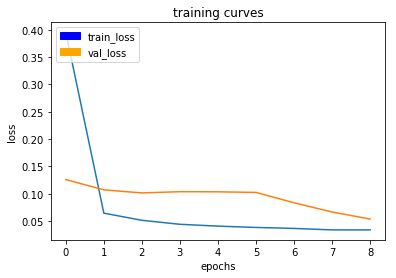

64/64 [==============================] - 112s - loss: 0.0338 - val_loss: 0.0535
Epoch 10/100
63/64 [============================>.] - ETA: 1s - loss: 0.0300

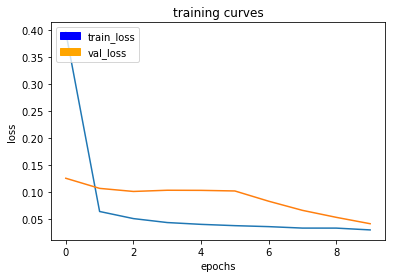

64/64 [==============================] - 112s - loss: 0.0303 - val_loss: 0.0418
Epoch 11/100
63/64 [============================>.] - ETA: 1s - loss: 0.0310

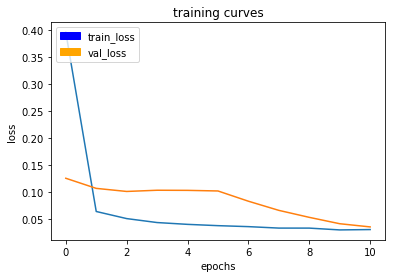

64/64 [==============================] - 112s - loss: 0.0310 - val_loss: 0.0359
Epoch 12/100
63/64 [============================>.] - ETA: 1s - loss: 0.0334

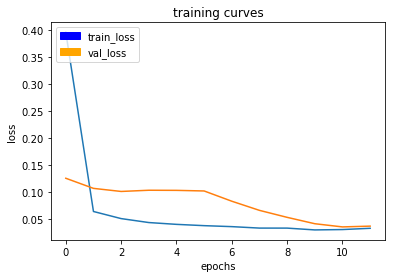

64/64 [==============================] - 112s - loss: 0.0333 - val_loss: 0.0373
Epoch 13/100
63/64 [============================>.] - ETA: 1s - loss: 0.0297

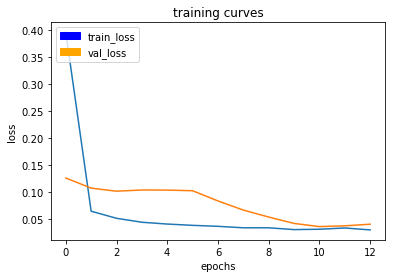

64/64 [==============================] - 112s - loss: 0.0297 - val_loss: 0.0403
Epoch 14/100
63/64 [============================>.] - ETA: 1s - loss: 0.0269

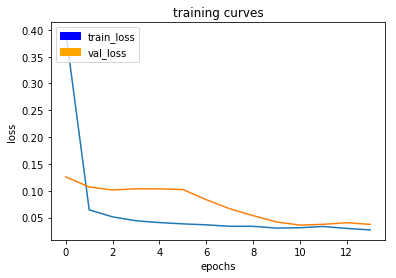

64/64 [==============================] - 112s - loss: 0.0269 - val_loss: 0.0373
Epoch 15/100
63/64 [============================>.] - ETA: 1s - loss: 0.0275

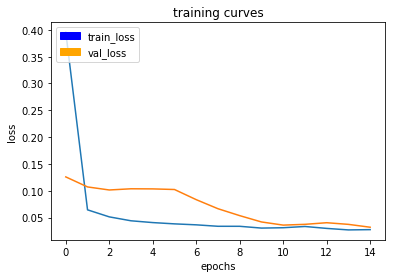

64/64 [==============================] - 112s - loss: 0.0274 - val_loss: 0.0319
Epoch 16/100
63/64 [============================>.] - ETA: 1s - loss: 0.0264

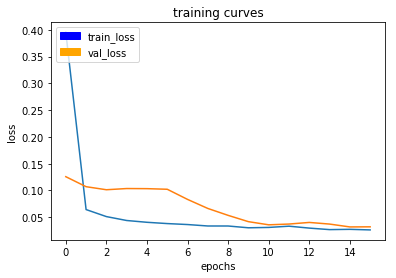

64/64 [==============================] - 111s - loss: 0.0263 - val_loss: 0.0321
Epoch 17/100
63/64 [============================>.] - ETA: 1s - loss: 0.0262

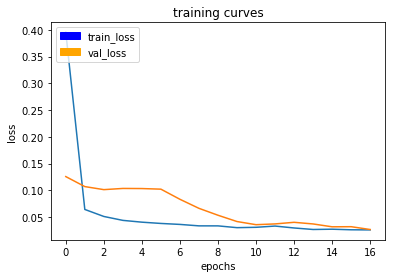

64/64 [==============================] - 112s - loss: 0.0262 - val_loss: 0.0269
Epoch 18/100
63/64 [============================>.] - ETA: 1s - loss: 0.0242

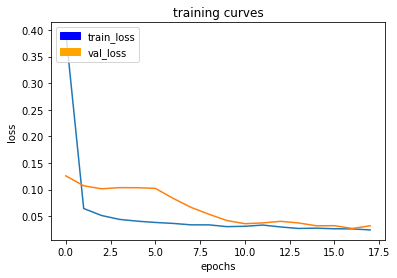

64/64 [==============================] - 112s - loss: 0.0242 - val_loss: 0.0320
Epoch 19/100
63/64 [============================>.] - ETA: 1s - loss: 0.0252

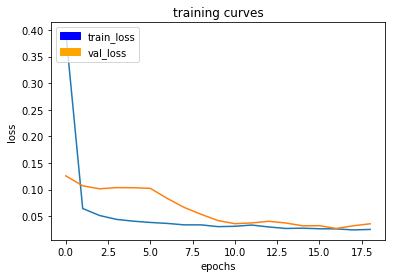

64/64 [==============================] - 112s - loss: 0.0251 - val_loss: 0.0357
Epoch 20/100
63/64 [============================>.] - ETA: 1s - loss: 0.0429

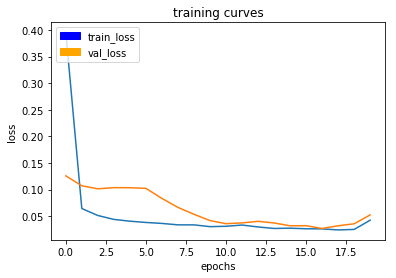

64/64 [==============================] - 112s - loss: 0.0427 - val_loss: 0.0524
Epoch 21/100
63/64 [============================>.] - ETA: 1s - loss: 0.0285

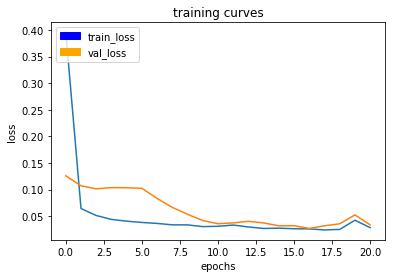

64/64 [==============================] - 112s - loss: 0.0285 - val_loss: 0.0336
Epoch 22/100
63/64 [============================>.] - ETA: 1s - loss: 0.0250

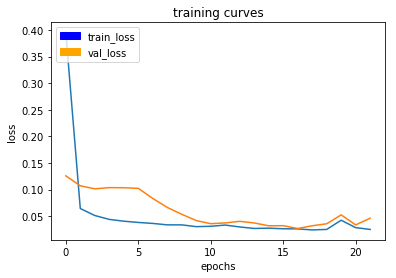

64/64 [==============================] - 112s - loss: 0.0251 - val_loss: 0.0462
Epoch 23/100
63/64 [============================>.] - ETA: 1s - loss: 0.0257

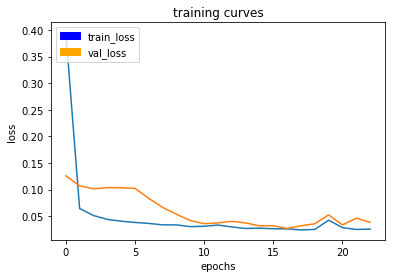

64/64 [==============================] - 111s - loss: 0.0257 - val_loss: 0.0385
Epoch 24/100
63/64 [============================>.] - ETA: 1s - loss: 0.0237

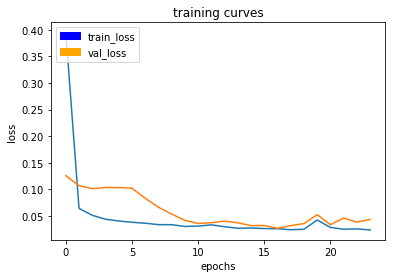

64/64 [==============================] - 111s - loss: 0.0238 - val_loss: 0.0434
Epoch 25/100
63/64 [============================>.] - ETA: 1s - loss: 0.0232

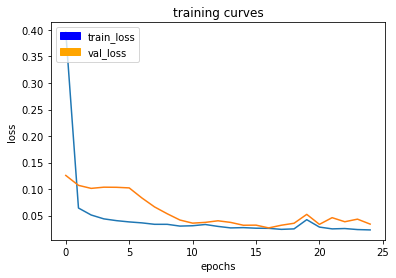

64/64 [==============================] - 113s - loss: 0.0232 - val_loss: 0.0341
Epoch 26/100
63/64 [============================>.] - ETA: 1s - loss: 0.0244

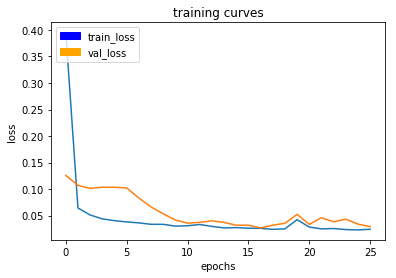

64/64 [==============================] - 112s - loss: 0.0244 - val_loss: 0.0294
Epoch 27/100
63/64 [============================>.] - ETA: 1s - loss: 0.0224

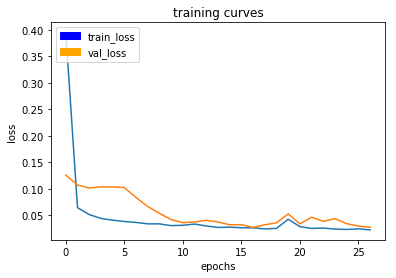

64/64 [==============================] - 111s - loss: 0.0224 - val_loss: 0.0273
Epoch 28/100
63/64 [============================>.] - ETA: 1s - loss: 0.0222

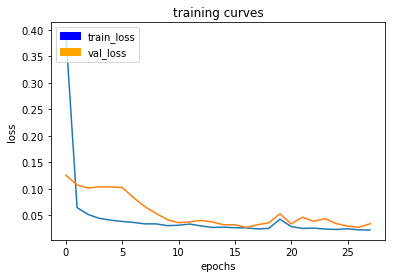

64/64 [==============================] - 112s - loss: 0.0222 - val_loss: 0.0340
Epoch 29/100
63/64 [============================>.] - ETA: 1s - loss: 0.0219

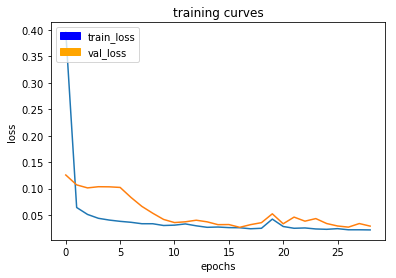

64/64 [==============================] - 112s - loss: 0.0220 - val_loss: 0.0292
Epoch 30/100
63/64 [============================>.] - ETA: 1s - loss: 0.0220

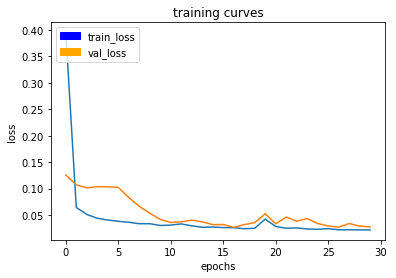

64/64 [==============================] - 112s - loss: 0.0219 - val_loss: 0.0277
Epoch 31/100
63/64 [============================>.] - ETA: 1s - loss: 0.0249

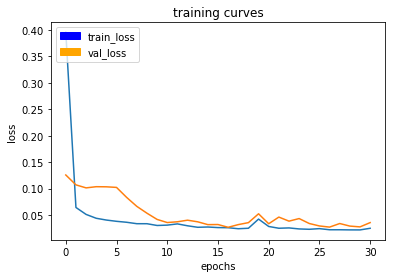

64/64 [==============================] - 112s - loss: 0.0251 - val_loss: 0.0358
Epoch 32/100
63/64 [============================>.] - ETA: 1s - loss: 0.0207

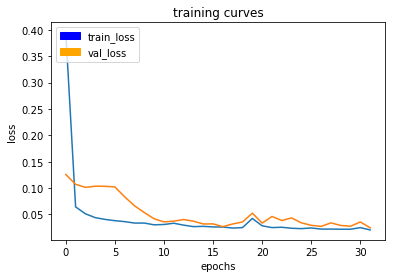

64/64 [==============================] - 112s - loss: 0.0207 - val_loss: 0.0246
Epoch 33/100
63/64 [============================>.] - ETA: 1s - loss: 0.0227

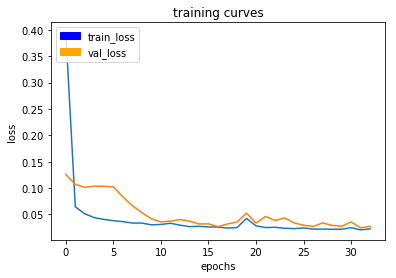

64/64 [==============================] - 112s - loss: 0.0227 - val_loss: 0.0274
Epoch 34/100
63/64 [============================>.] - ETA: 1s - loss: 0.0205

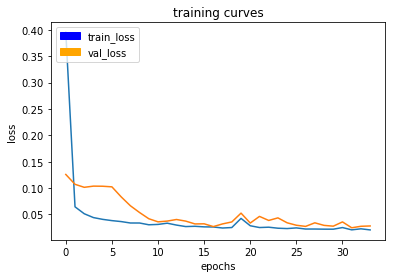

64/64 [==============================] - 113s - loss: 0.0206 - val_loss: 0.0281
Epoch 35/100
63/64 [============================>.] - ETA: 1s - loss: 0.0212

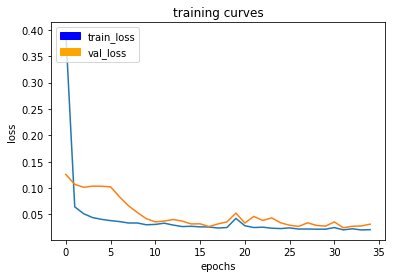

64/64 [==============================] - 112s - loss: 0.0212 - val_loss: 0.0315
Epoch 36/100
63/64 [============================>.] - ETA: 1s - loss: 0.0199

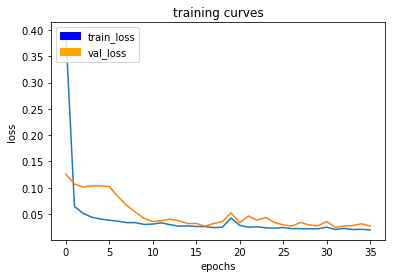

64/64 [==============================] - 111s - loss: 0.0198 - val_loss: 0.0273
Epoch 37/100
63/64 [============================>.] - ETA: 1s - loss: 0.0203

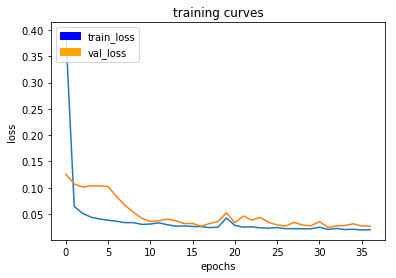

64/64 [==============================] - 112s - loss: 0.0202 - val_loss: 0.0270
Epoch 38/100
63/64 [============================>.] - ETA: 1s - loss: 0.0199

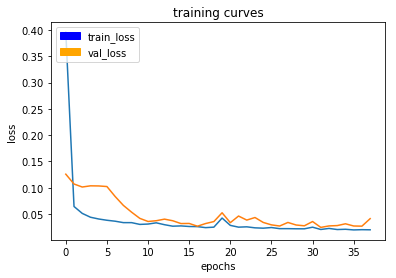

64/64 [==============================] - 112s - loss: 0.0200 - val_loss: 0.0413
Epoch 39/100
63/64 [============================>.] - ETA: 1s - loss: 0.0214

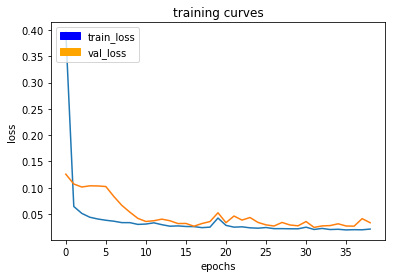

64/64 [==============================] - 112s - loss: 0.0214 - val_loss: 0.0335
Epoch 40/100
63/64 [============================>.] - ETA: 1s - loss: 0.0199

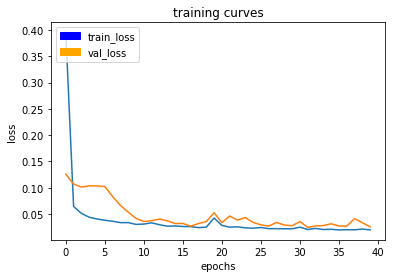

64/64 [==============================] - 113s - loss: 0.0199 - val_loss: 0.0260
Epoch 41/100
63/64 [============================>.] - ETA: 1s - loss: 0.0191

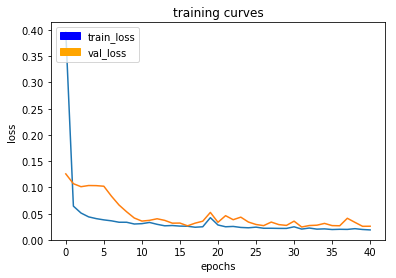

64/64 [==============================] - 112s - loss: 0.0191 - val_loss: 0.0261
Epoch 42/100
63/64 [============================>.] - ETA: 1s - loss: 0.0189

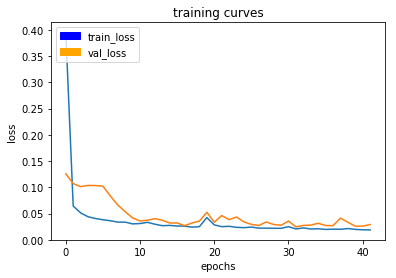

64/64 [==============================] - 112s - loss: 0.0189 - val_loss: 0.0291
Epoch 43/100
63/64 [============================>.] - ETA: 1s - loss: 0.0200

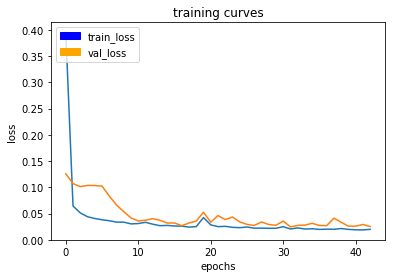

64/64 [==============================] - 112s - loss: 0.0199 - val_loss: 0.0253
Epoch 44/100
63/64 [============================>.] - ETA: 1s - loss: 0.0191

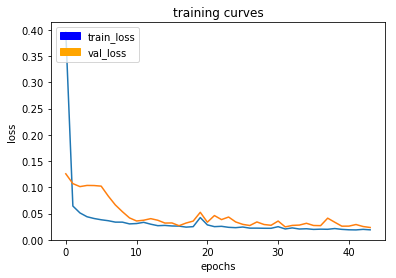

64/64 [==============================] - 112s - loss: 0.0190 - val_loss: 0.0235
Epoch 45/100
63/64 [============================>.] - ETA: 1s - loss: 0.0213

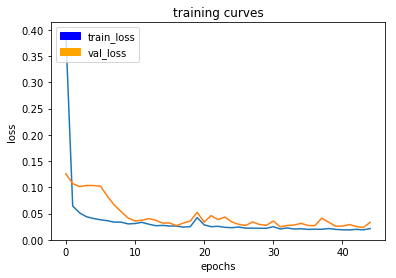

64/64 [==============================] - 112s - loss: 0.0213 - val_loss: 0.0332
Epoch 46/100
63/64 [============================>.] - ETA: 1s - loss: 0.0187

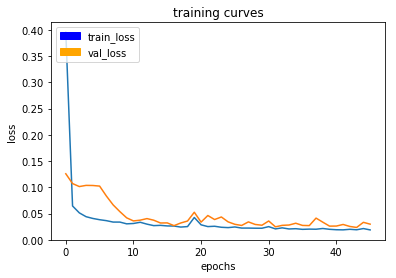

64/64 [==============================] - 112s - loss: 0.0187 - val_loss: 0.0297
Epoch 47/100
63/64 [============================>.] - ETA: 1s - loss: 0.0187

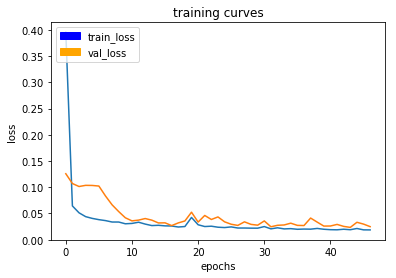

64/64 [==============================] - 112s - loss: 0.0186 - val_loss: 0.0249
Epoch 48/100
63/64 [============================>.] - ETA: 1s - loss: 0.0178

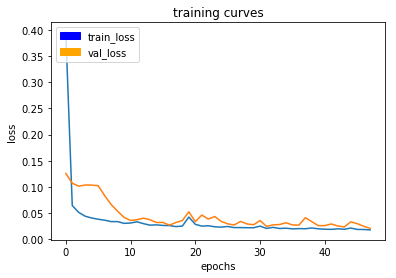

64/64 [==============================] - 112s - loss: 0.0178 - val_loss: 0.0207
Epoch 49/100
63/64 [============================>.] - ETA: 1s - loss: 0.0182

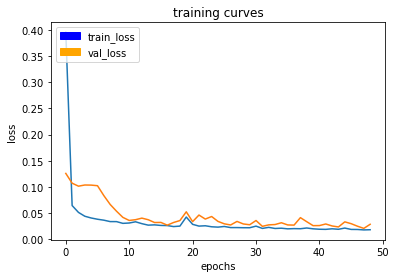

64/64 [==============================] - 111s - loss: 0.0182 - val_loss: 0.0286
Epoch 50/100
63/64 [============================>.] - ETA: 1s - loss: 0.0174

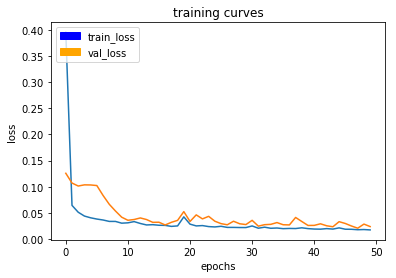

64/64 [==============================] - 113s - loss: 0.0174 - val_loss: 0.0238
Epoch 51/100
63/64 [============================>.] - ETA: 1s - loss: 0.0176

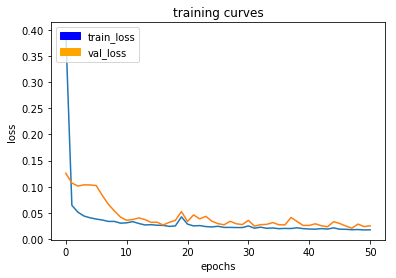

64/64 [==============================] - 111s - loss: 0.0176 - val_loss: 0.0252
Epoch 52/100
63/64 [============================>.] - ETA: 1s - loss: 0.0176

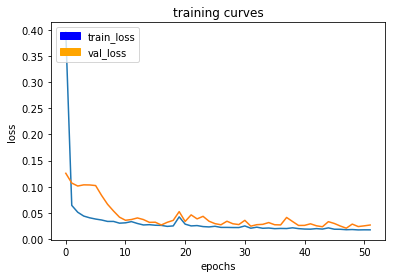

64/64 [==============================] - 112s - loss: 0.0176 - val_loss: 0.0268
Epoch 53/100
63/64 [============================>.] - ETA: 1s - loss: 0.0179

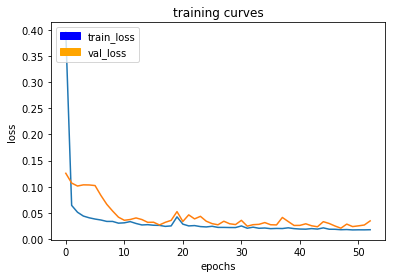

64/64 [==============================] - 113s - loss: 0.0178 - val_loss: 0.0347
Epoch 54/100
63/64 [============================>.] - ETA: 1s - loss: 0.0187

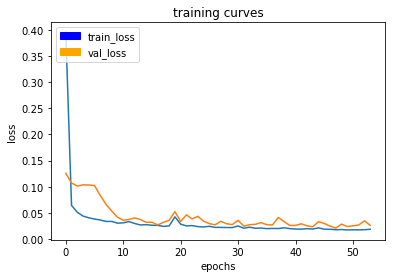

64/64 [==============================] - 111s - loss: 0.0187 - val_loss: 0.0263
Epoch 55/100
63/64 [============================>.] - ETA: 1s - loss: 0.0173

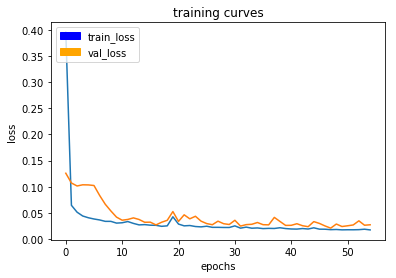

64/64 [==============================] - 112s - loss: 0.0173 - val_loss: 0.0271
Epoch 56/100
63/64 [============================>.] - ETA: 1s - loss: 0.0174

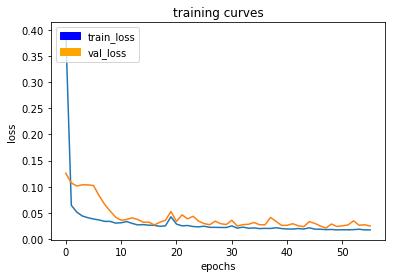

64/64 [==============================] - 112s - loss: 0.0174 - val_loss: 0.0248
Epoch 57/100
63/64 [============================>.] - ETA: 1s - loss: 0.0170

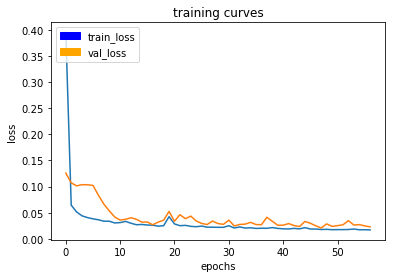

64/64 [==============================] - 112s - loss: 0.0170 - val_loss: 0.0228
Epoch 58/100
63/64 [============================>.] - ETA: 1s - loss: 0.0171

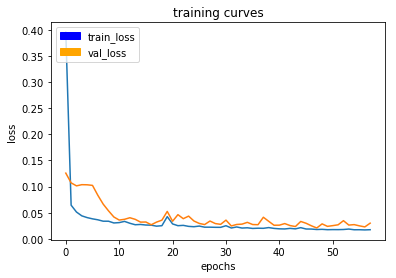

64/64 [==============================] - 112s - loss: 0.0174 - val_loss: 0.0299
Epoch 59/100
63/64 [============================>.] - ETA: 1s - loss: 0.0176

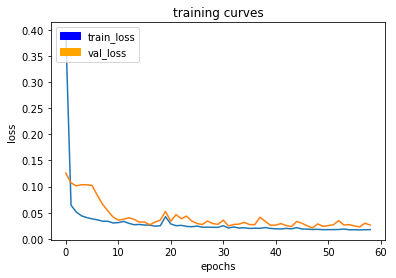

64/64 [==============================] - 112s - loss: 0.0176 - val_loss: 0.0263
Epoch 60/100
63/64 [============================>.] - ETA: 1s - loss: 0.0164

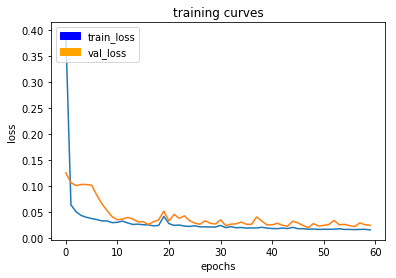

64/64 [==============================] - 112s - loss: 0.0164 - val_loss: 0.0252
Epoch 61/100
63/64 [============================>.] - ETA: 1s - loss: 0.0161

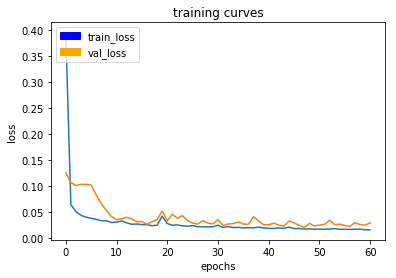

64/64 [==============================] - 112s - loss: 0.0161 - val_loss: 0.0297
Epoch 62/100
63/64 [============================>.] - ETA: 1s - loss: 0.0172

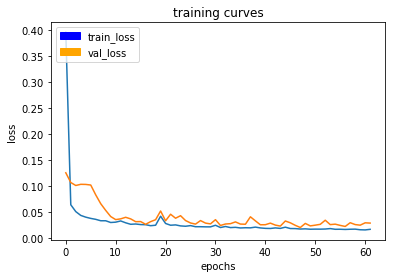

64/64 [==============================] - 111s - loss: 0.0172 - val_loss: 0.0292
Epoch 63/100
63/64 [============================>.] - ETA: 1s - loss: 0.0178

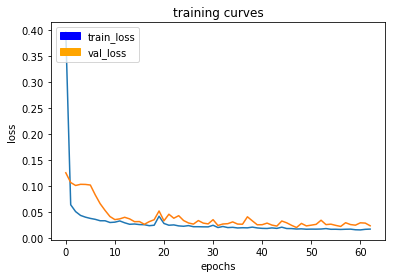

64/64 [==============================] - 112s - loss: 0.0177 - val_loss: 0.0241
Epoch 64/100
63/64 [============================>.] - ETA: 1s - loss: 0.0168

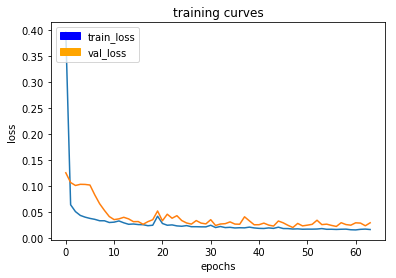

64/64 [==============================] - 111s - loss: 0.0168 - val_loss: 0.0298
Epoch 65/100
63/64 [============================>.] - ETA: 1s - loss: 0.0165

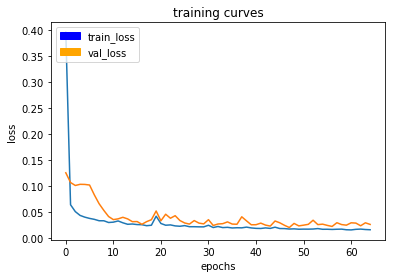

64/64 [==============================] - 112s - loss: 0.0164 - val_loss: 0.0266
Epoch 66/100
63/64 [============================>.] - ETA: 1s - loss: 0.0159

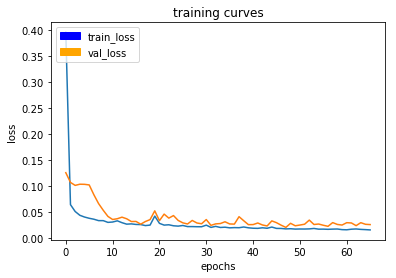

64/64 [==============================] - 112s - loss: 0.0158 - val_loss: 0.0261
Epoch 67/100
63/64 [============================>.] - ETA: 1s - loss: 0.0158

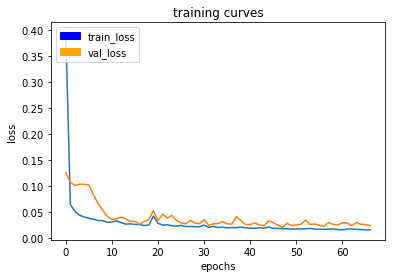

64/64 [==============================] - 113s - loss: 0.0158 - val_loss: 0.0238
Epoch 68/100
63/64 [============================>.] - ETA: 1s - loss: 0.0157

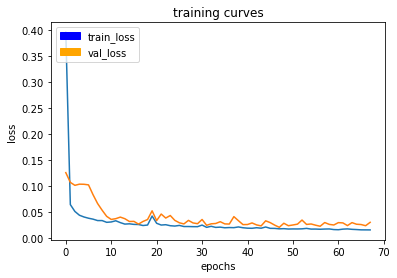

64/64 [==============================] - 112s - loss: 0.0157 - val_loss: 0.0303
Epoch 69/100
63/64 [============================>.] - ETA: 1s - loss: 0.0160

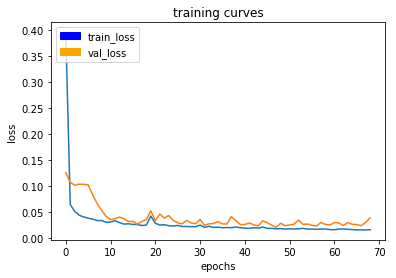

64/64 [==============================] - 112s - loss: 0.0161 - val_loss: 0.0389
Epoch 70/100
63/64 [============================>.] - ETA: 1s - loss: 0.0161

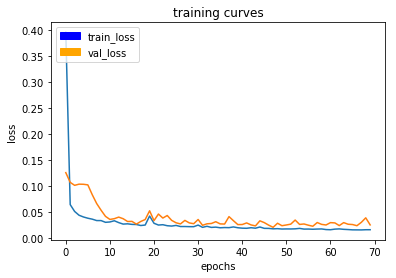

64/64 [==============================] - 112s - loss: 0.0161 - val_loss: 0.0254
Epoch 71/100
63/64 [============================>.] - ETA: 1s - loss: 0.0165

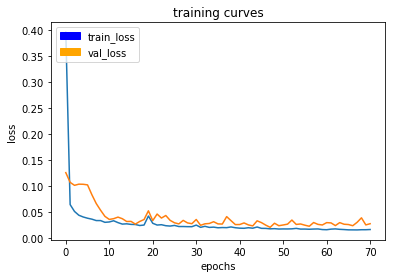

64/64 [==============================] - 112s - loss: 0.0165 - val_loss: 0.0276
Epoch 72/100
63/64 [============================>.] - ETA: 1s - loss: 0.0154

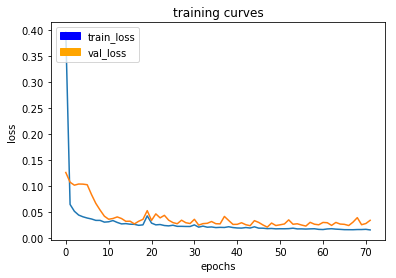

64/64 [==============================] - 111s - loss: 0.0153 - val_loss: 0.0338
Epoch 73/100
63/64 [============================>.] - ETA: 1s - loss: 0.0161

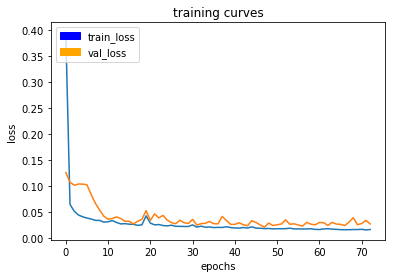

64/64 [==============================] - 113s - loss: 0.0161 - val_loss: 0.0268
Epoch 74/100
63/64 [============================>.] - ETA: 1s - loss: 0.0153

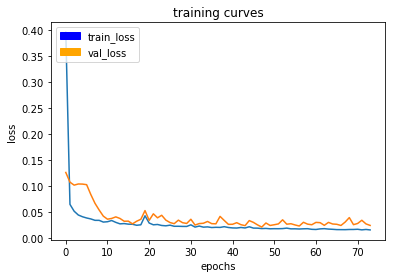

64/64 [==============================] - 111s - loss: 0.0152 - val_loss: 0.0239
Epoch 75/100
63/64 [============================>.] - ETA: 1s - loss: 0.0156

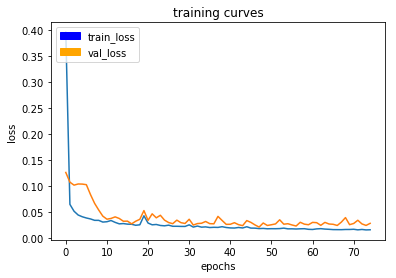

64/64 [==============================] - 113s - loss: 0.0155 - val_loss: 0.0279
Epoch 76/100
63/64 [============================>.] - ETA: 1s - loss: 0.0148

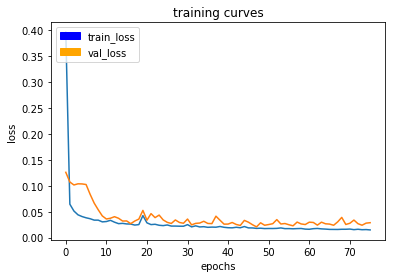

64/64 [==============================] - 112s - loss: 0.0148 - val_loss: 0.0287
Epoch 77/100
63/64 [============================>.] - ETA: 1s - loss: 0.0163

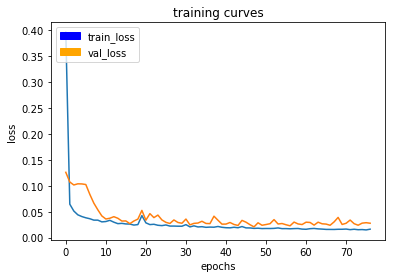

64/64 [==============================] - 111s - loss: 0.0163 - val_loss: 0.0277
Epoch 78/100
63/64 [============================>.] - ETA: 1s - loss: 0.0147

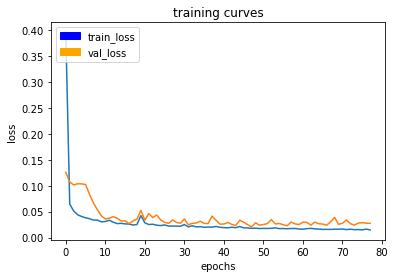

64/64 [==============================] - 112s - loss: 0.0147 - val_loss: 0.0274
Epoch 79/100
63/64 [============================>.] - ETA: 1s - loss: 0.0152

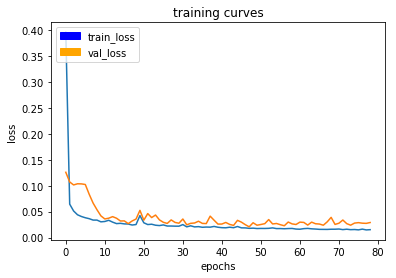

64/64 [==============================] - 112s - loss: 0.0152 - val_loss: 0.0290
Epoch 80/100
63/64 [============================>.] - ETA: 1s - loss: 0.0146

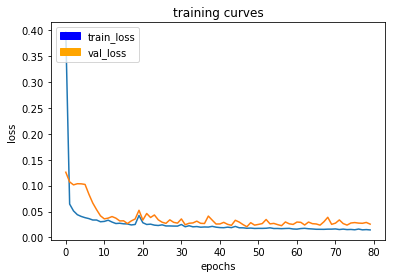

64/64 [==============================] - 112s - loss: 0.0146 - val_loss: 0.0257
Epoch 81/100
63/64 [============================>.] - ETA: 1s - loss: 0.0144

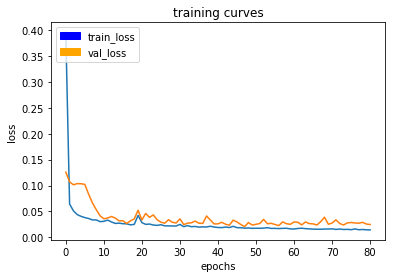

64/64 [==============================] - 112s - loss: 0.0144 - val_loss: 0.0248
Epoch 82/100
63/64 [============================>.] - ETA: 1s - loss: 0.0143

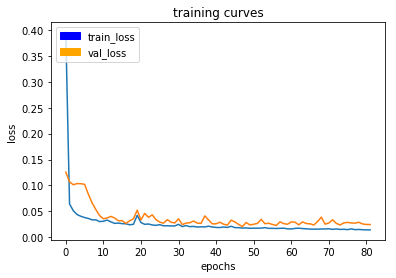

64/64 [==============================] - 112s - loss: 0.0143 - val_loss: 0.0246
Epoch 83/100
63/64 [============================>.] - ETA: 1s - loss: 0.0147

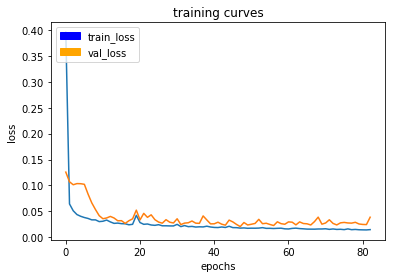

64/64 [==============================] - 113s - loss: 0.0148 - val_loss: 0.0388
Epoch 84/100
63/64 [============================>.] - ETA: 1s - loss: 0.0147

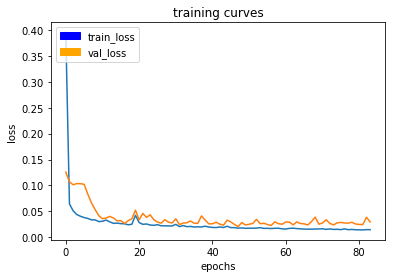

64/64 [==============================] - 112s - loss: 0.0147 - val_loss: 0.0296
Epoch 85/100
63/64 [============================>.] - ETA: 1s - loss: 0.0144

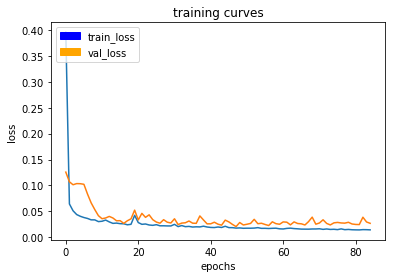

64/64 [==============================] - 111s - loss: 0.0144 - val_loss: 0.0270
Epoch 86/100
63/64 [============================>.] - ETA: 1s - loss: 0.0137

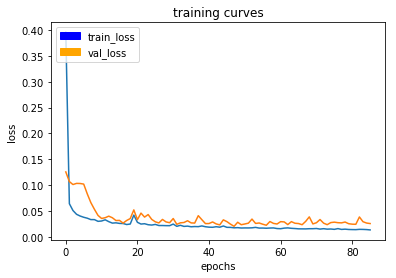

64/64 [==============================] - 112s - loss: 0.0138 - val_loss: 0.0260
Epoch 87/100
63/64 [============================>.] - ETA: 1s - loss: 0.0155

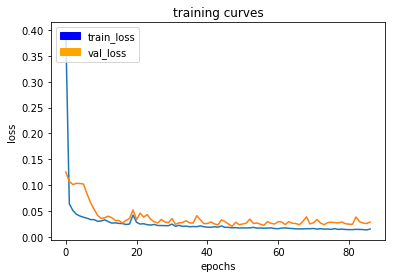

64/64 [==============================] - 111s - loss: 0.0155 - val_loss: 0.0289
Epoch 88/100
63/64 [============================>.] - ETA: 1s - loss: 0.0156

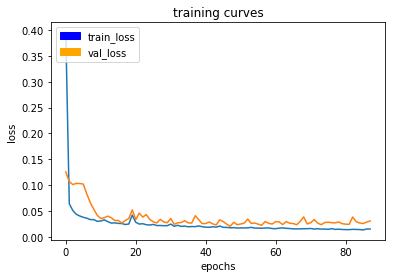

64/64 [==============================] - 112s - loss: 0.0156 - val_loss: 0.0311
Epoch 89/100
63/64 [============================>.] - ETA: 1s - loss: 0.0141

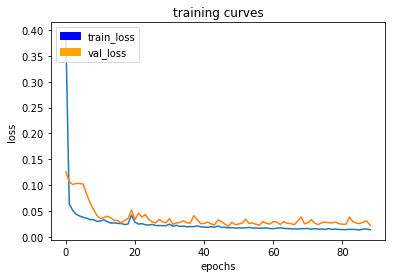

64/64 [==============================] - 112s - loss: 0.0141 - val_loss: 0.0227
Epoch 90/100
63/64 [============================>.] - ETA: 1s - loss: 0.0142

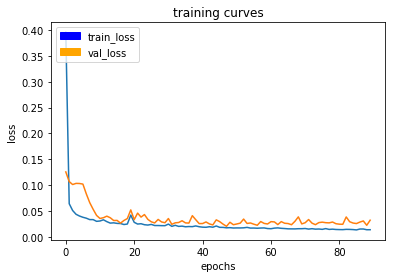

64/64 [==============================] - 112s - loss: 0.0142 - val_loss: 0.0325
Epoch 91/100
63/64 [============================>.] - ETA: 1s - loss: 0.0139

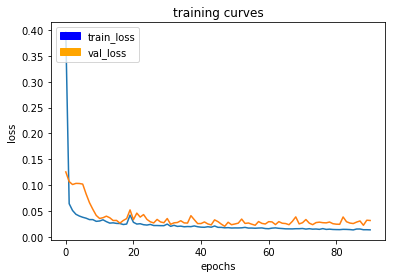

64/64 [==============================] - 112s - loss: 0.0139 - val_loss: 0.0320
Epoch 92/100
63/64 [============================>.] - ETA: 1s - loss: 0.0153

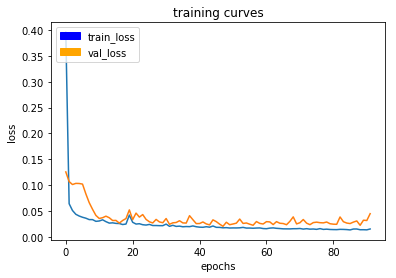

64/64 [==============================] - 111s - loss: 0.0156 - val_loss: 0.0451
Epoch 93/100
63/64 [============================>.] - ETA: 1s - loss: 0.0228

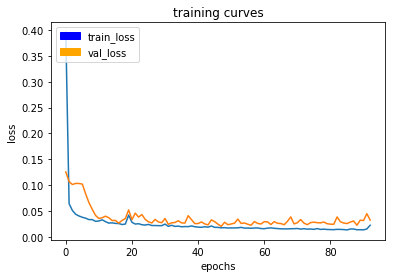

64/64 [==============================] - 112s - loss: 0.0227 - val_loss: 0.0328
Epoch 94/100
63/64 [============================>.] - ETA: 1s - loss: 0.0164

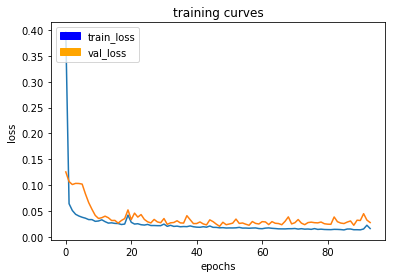

64/64 [==============================] - 112s - loss: 0.0164 - val_loss: 0.0280
Epoch 95/100
63/64 [============================>.] - ETA: 1s - loss: 0.0149

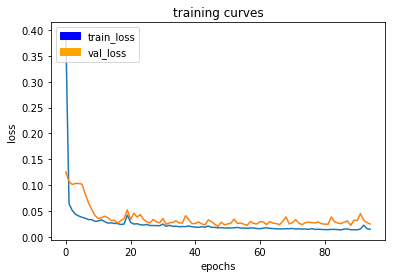

64/64 [==============================] - 111s - loss: 0.0149 - val_loss: 0.0251
Epoch 96/100
63/64 [============================>.] - ETA: 1s - loss: 0.0141

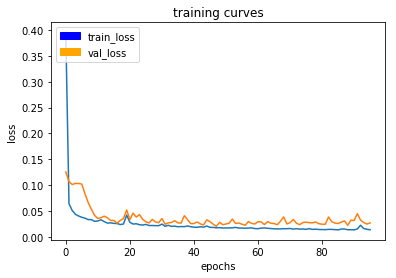

64/64 [==============================] - 112s - loss: 0.0141 - val_loss: 0.0273
Epoch 97/100
63/64 [============================>.] - ETA: 1s - loss: 0.0142

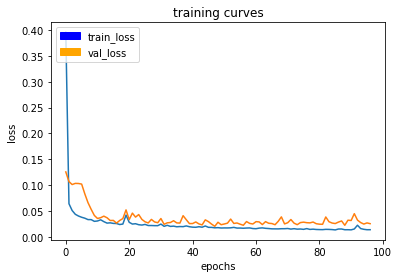

64/64 [==============================] - 112s - loss: 0.0142 - val_loss: 0.0258
Epoch 98/100
63/64 [============================>.] - ETA: 1s - loss: 0.0153

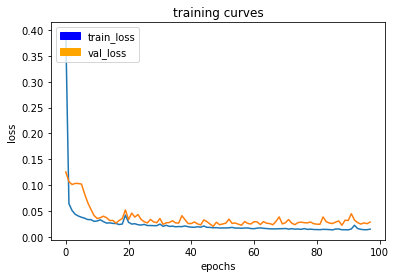

64/64 [==============================] - 113s - loss: 0.0152 - val_loss: 0.0290
Epoch 99/100
63/64 [============================>.] - ETA: 1s - loss: 0.0135

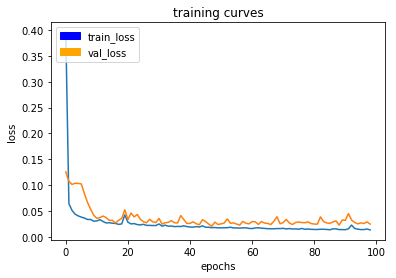

64/64 [==============================] - 111s - loss: 0.0135 - val_loss: 0.0247
Epoch 100/100
63/64 [============================>.] - ETA: 1s - loss: 0.0135

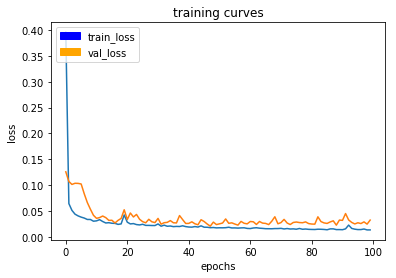

64/64 [==============================] - 112s - loss: 0.0135 - val_loss: 0.0325


In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

#model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')
model.compile(optimizer=keras.optimizers.Nadam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [14]:
# Save your trained model weights
weight_file_name = 'trained_model-ec2-NIN.h5'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [2]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'trained_model-ec2-NIN.h5'
model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [3]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

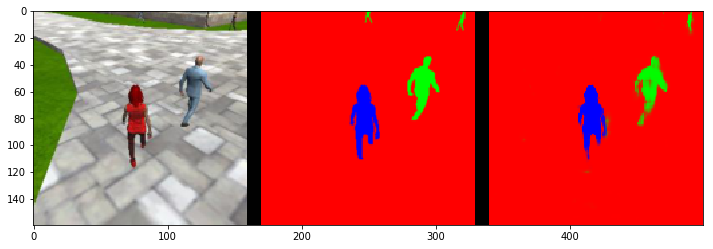

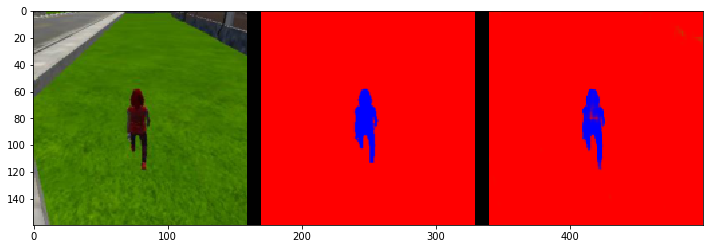

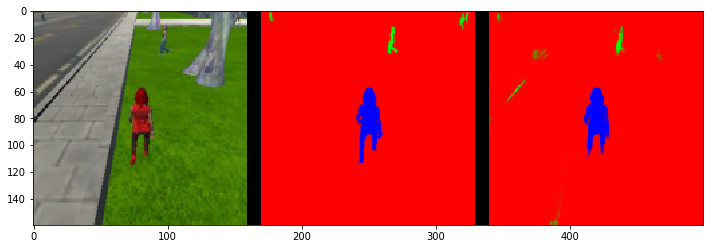

In [4]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

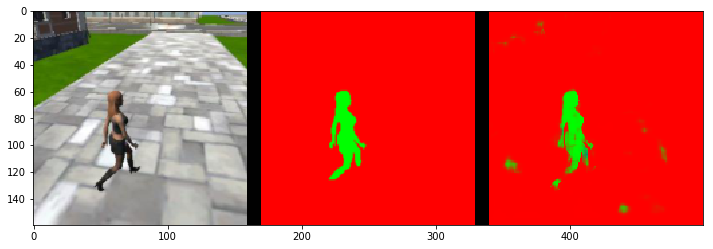

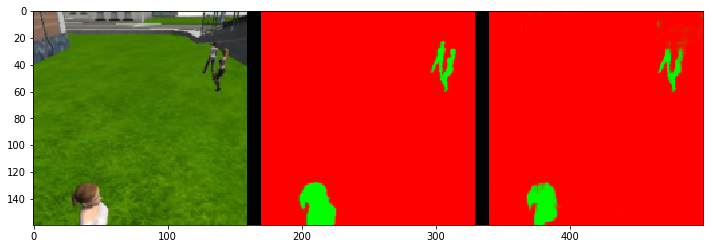

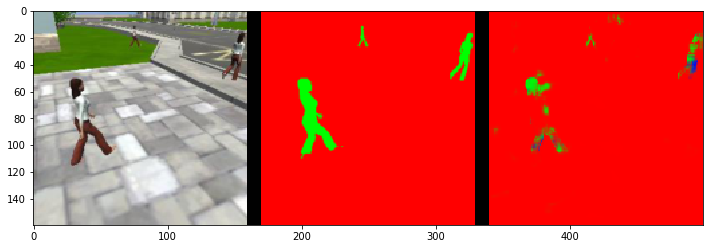

In [5]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

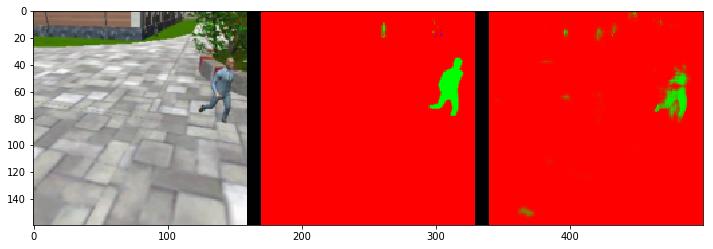

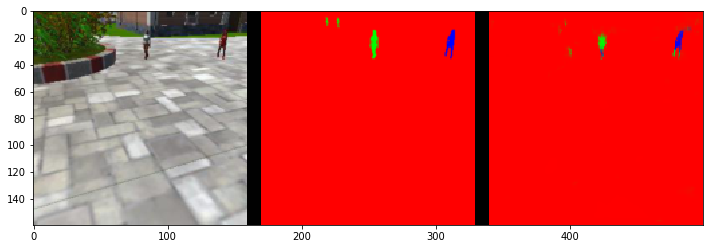

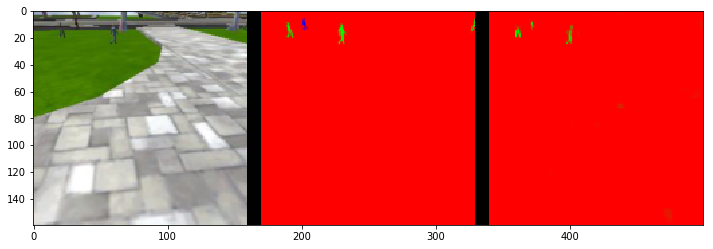

In [10]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [19]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.995492514269056
average intersection over union for other people is 0.3403779627884988
average intersection over union for the hero is 0.8866361609178215
number true positives: 539, number false positives: 0, number false negatives: 0


In [20]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9867655742141551
average intersection over union for other people is 0.7354564797240133
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 52, number false negatives: 0


In [21]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9962545450133841
average intersection over union for other people is 0.43931262328577486
average intersection over union for the hero is 0.23568890315797367
number true positives: 148, number false positives: 1, number false negatives: 153


In [22]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7693169092945129


In [23]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.561162532038


In [24]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.431711824759
